In [61]:
# import libs
from decouple import Config, RepositoryEnv, Csv #https://github.com/HBNetwork/python-decouple/issues/116
import numpy as np
import pymysql
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import tensorflow_model_optimization as tfmot
import keras
from keras.utils import plot_model
import pydot, graphviz
from random import random

In [98]:
config = Config(RepositoryEnv("/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/.env"))
conn = pymysql.connect(
    host=config('myhost'),
    user=config('myuser'),
    password=config('mypassword'),
    database=config('mydatabase'),
    cursorclass=pymysql.cursors.DictCursor)

In [99]:
cur = conn.cursor()
#cur.execute("SELECT * FROM data WHERE timestamp > 1696221020000 AND device = 1 LIMIT 10000")

cur.execute("SELECT * FROM data WHERE device = 1 LIMIT 10000")
# get all rows where device is active
dictlist_device1 = cur.fetchall()

cur.execute("SELECT * FROM data WHERE device = 2 LIMIT 10000")
# get all rows where device is active
dictlist_device2 = cur.fetchall()

cur.execute("SELECT * FROM data WHERE device = 4 LIMIT 10000")
# get all rows where device is active
dictlist_device4 = cur.fetchall()

conn.close()

In [101]:
x = np.array([])
y = np.array([])

size_x = x.size
active = False
for row in dictlist_device1 : 
    if not active : 
        if row['value'] > 800 : 
            active = True
            x = np.append(x, 200 + (random() - 0.5) * abs(100))
            x = np.append(x, row['value'])
    else :
        if row['value'] > 800 :  
            x = np.append(x, row['value'])
        else :
            active = False
            x = np.append(x, 200 + (random() - 0.5) * abs(100))

y = np.append(y, np.full(x.size - size_x, 1, dtype=int))

In [102]:
size_x = x.size
active = False
for row in dictlist_device2 : 
    if not active : 
        if row['value'] > 800 : 
            active = True
            x = np.append(x, 200 + (random() - 0.5) * abs(100))
            x = np.append(x, row['value'])
    else :
        if row['value'] > 800 :  
            x = np.append(x, row['value'])
        else :
            active = False
            x = np.append(x, 200 + (random() - 0.5) * abs(100))

y = np.append(y, np.full(x.size - size_x, 2, dtype=int))

In [103]:
size_x = x.size
active = False
for row in dictlist_device4 : 
    if not active : 
        if row['value'] > 800 : 
            active = True
            x = np.append(x, 200 + (random() - 0.5) * abs(100))
            x = np.append(x, row['value'])
    else :
        if row['value'] > 800 :  
            x = np.append(x, row['value'])
        else :
            active = False
            x = np.append(x, 200 + (random() - 0.5) * abs(100))

y = np.append(y, np.full(x.size - size_x, 4, dtype=int))

9641

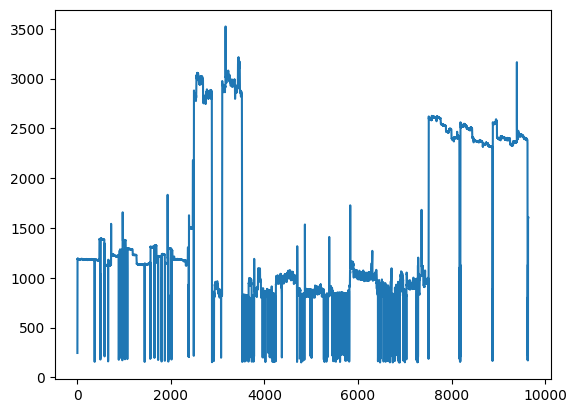

In [106]:
plt.plot(x)
x.size

9641

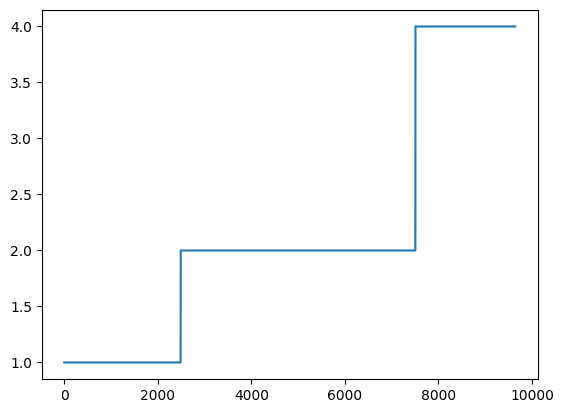

In [107]:
plt.plot(y)
y.size

In [ ]:
# configuration
num_features = 5
window_length = 20
batch_size = num_features * 200 # https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
model = Sequential()
rnd = 0.1
epochs = 300
test_batch_size  = 2000

In [ ]:
# input layer
model.add(Input(shape=(window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(window_length, 1)))
# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(num_features, activation="softmax"))

In [ ]:
# TensorBoard 2.15.1 at http://localhost:6006/
#keras.callbacks.TensorBoard(
#    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",
#    histogram_freq=0,  # How often to log histogram visualizations
#    embeddings_freq=0,  # How often to log embedding visualizations
#    update_freq="epoch",
#)  # How often to write logs (default: once per epoch)

In [ ]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

In [ ]:
# feature1
def generate_feature(base, peak, width=6, amount=1, rnd=0, size=10) :
    a = np.array([])
    for t in range(amount) :
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
        a = np.append(a, [peak + (random() - 0.5) * abs(rnd) for i in np.arange(size // amount - 2)])
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
    a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(size % amount)]) # correction for uneven num_features
    return a

In [ ]:
x = np.array([])
y = np.array([])
for f in range(num_features) :
    for i in range(batch_size // num_features) :
        new_feature = generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length)
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        x = np.append(x, new_feature)
        y = np.append(y, new_targets)
    plt.plot(new_feature)

In [ ]:
plt.plot(x)

In [ ]:
x = x.reshape((batch_size, window_length))
y = y.reshape((batch_size, num_features))

In [ ]:
keras.utils.plot_model(model, "my_new_nilm_model.png", show_shapes=True)

In [ ]:
# train the model
history = model.fit(
            x=x.reshape(batch_size, window_length),
            y=y.reshape(batch_size, num_features ),
            batch_size=batch_size,
            epochs=epochs)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
plt.plot(history.history['mse'])

In [ ]:
plt.plot(history.history['msle'])

In [ ]:
plt.plot(history.history['mae'])

In [ ]:
model.save("my_new_nilm_model.keras")

In [ ]:
test_x = np.array([])
test_y = np.array([])

for f in range(num_features) :
    for i in range(int(test_batch_size / num_features)) :
        test_x = np.append(test_x, generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length))
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        test_y = np.append(test_y, new_targets)
        
test_x = test_x.reshape((test_batch_size, window_length))
test_y = test_y.reshape((test_batch_size, num_features))

In [ ]:
# loss='mse', metrics=['mse', 'msle', 'mae']
test1, test2, test3, test4 = model.evaluate(test_x, test_y)

In [ ]:
predict_x = test_x
predict_x = predict_x.reshape(predict_x.shape[0], window_length)

In [ ]:
predict_y = model.predict(predict_x)
print(predict_y)

In [ ]:
predict_y.shape[0]

In [ ]:
predict_y

In [ ]:
cnt_wrong = 0
cnt_correct = 0

for i in range(predict_y.shape[0]) :
    predicted_pos = np.argmax(predict_y[i])
    trained_pos =  np.argmax(test_y[i])
    if predicted_pos != trained_pos :
        cnt_wrong = cnt_wrong + 1
        #print("predicted feature: ", predicted_pos, " and trained feature: ", trained_pos)
        print("predicted: ", predict_y[i], " and trained: ", test_y[i])
        plt.plot(predict_x[i])
    else :
        cnt_correct = cnt_correct + 1

In [ ]:
print("predictions... ")
print(" total:   ", cnt_wrong + cnt_correct)
print(" correct: ", cnt_correct)
print(" wrong:   ", cnt_wrong)